In [117]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, datasets
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAvgPool2D
import numpy as np
from matplotlib import pyplot as plt
import datetime
import tqdm
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


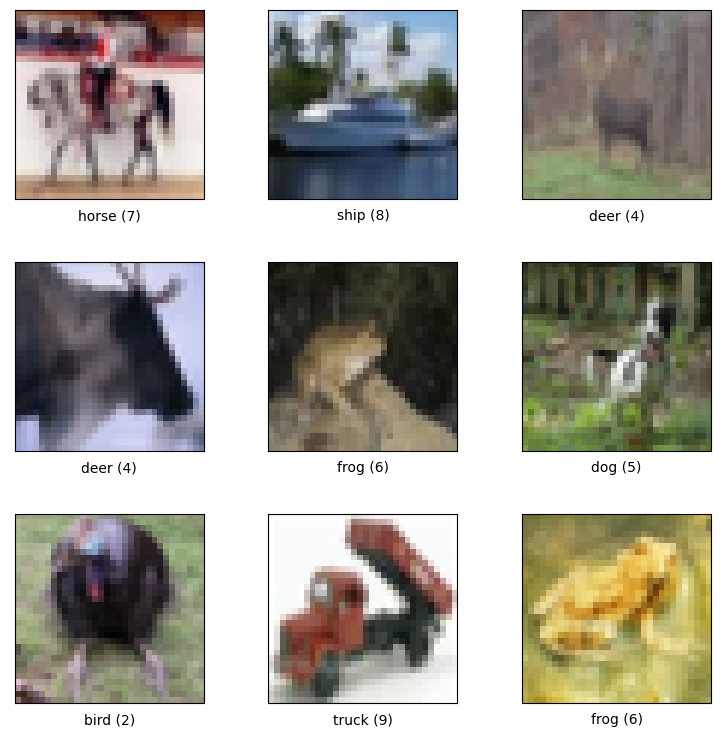

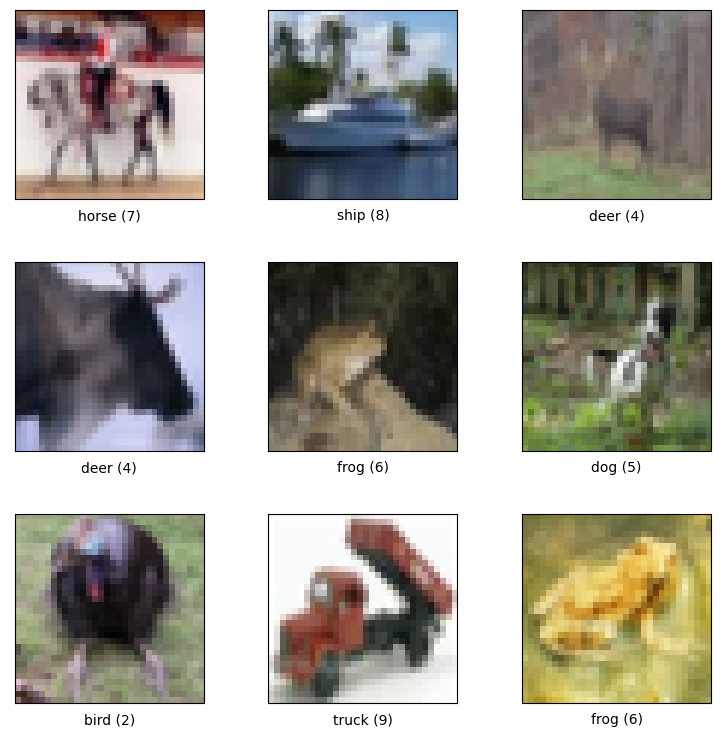

In [118]:
(train_ds, test_ds), ds_info = tfds.load(
    "cifar10", split=["train", "test"], as_supervised=True, with_info=True
)

tfds.show_examples(train_ds, ds_info)

In [119]:
def data_pipeline(data):
    """Creates a data pipeline function that prepares your data for use in your model."""
    data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
    data = data.map(lambda img, target: ((img / 128.)-1., target))
    data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    data = data.cache()
    data = data.shuffle(1000)
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)
    return data


train_ds = data_pipeline(train_ds)
test_ds = data_pipeline(test_ds)

In [120]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [121]:
class ConvolutionalNeuralNetwork(tf.keras.Model):

    def __init__(self, optimizer, loss_function) -> None:
        super().__init__()

        self.optimizer = optimizer
        self.loss_function = loss_function

        self.metrics_list = [
                tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.Mean(name="loss")
            ]

        self._activation_function_name = 'relu'
        self._output_activation_function_name = 'softmax'

        self.convolutional_layer_1 = Conv2D(filters=24, kernel_size=3, padding='same', activation=self._activation_function_name) 
        self.convolutional_layer_2 = Conv2D(filters=24, kernel_size=3, padding='same', activation=self._activation_function_name) 
        self.pooling = MaxPooling2D(pool_size=2, strides=2)

        self.convolutional_layer_3 = Conv2D(filters=48, kernel_size=3, padding='same', activation=self._activation_function_name) 
        self.convolutional_layer_4 = Conv2D(filters=48, kernel_size=3, padding='same', activation=self._activation_function_name)
        self.global_pool = GlobalAvgPool2D()

        self.out = Dense(10, activation=self._output_activation_function_name)
    

    @property
    def metrics(self):
        return self.metrics_list

    def call(self, input):
        input = self.convolutional_layer_1(input)
        input = self.convolutional_layer_2(input)
        input = self.pooling(input)
        input = self.convolutional_layer_3(input)
        input = self.convolutional_layer_4(input)
        input = self.global_pool(input)
        input = self.out(input)
        return input

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    def train_step(self, data):
        image, label = data

        with tf.GradientTape() as tape:
            prediction = self(image, training = True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)
        return {m.name: m.result() for m in self.metrics}


    def test_step(self, data):
        image, label = data
        prediction = self(image, training = False)
        loss = self.loss_function(label, prediction)
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)
        return {m.name: m.result() for m in self.metrics}


In [122]:
def write_metrics(model, metrics, writer, step, validation=False):
    """Writes metrics state to file."""
    with writer.as_default():
        for metric in model.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=step)
    if validation:
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])
    else:
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])


def training_loop(
    model, train_ds, val_ds, epochs, train_summary_writer, val_summary_writer, save_path
):

    for step in range(epochs):
        print(f'{step=}')
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)
        write_metrics(model, metrics, train_summary_writer, step)
        model.reset_metrics()

        for data in tqdm.tqdm(val_ds, position=0, leave=True):
            metrics = model.test_step(data)
        write_metrics(model, metrics, val_summary_writer, step, validation=True)
        model.reset_metrics()

    if save_path:
        model.save_weights(save_path)

In [123]:
optimizer = tf.keras.optimizers.Adam()
optimizer_name = 'adam'
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = ConvolutionalNeuralNetwork(optimizer=optimizer, loss_function=loss_function)
epochs = 5

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimizer_name}/{current_time}"
train_log_path = f"logs/{current_time}/train"
test_log_path = f"logs/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

step=0


100%|██████████| 1563/1563 [01:01<00:00, 25.49it/s]


['accuracy: 0.3693000078201294', 'loss: 1.6957131624221802']


100%|██████████| 313/313 [00:05<00:00, 59.19it/s]


['val_accuracy: 0.47749999165534973', 'val_loss: 1.4637458324432373']
step=1


100%|██████████| 1563/1563 [00:56<00:00, 27.49it/s]


['accuracy: 0.5171599984169006', 'loss: 1.34418785572052']


100%|██████████| 313/313 [00:04<00:00, 63.77it/s]


['val_accuracy: 0.5271000266075134', 'val_loss: 1.2896465063095093']
step=2


100%|██████████| 1563/1563 [00:56<00:00, 27.74it/s]


['accuracy: 0.5725399851799011', 'loss: 1.1989712715148926']


100%|██████████| 313/313 [00:04<00:00, 62.79it/s]


['val_accuracy: 0.6017000079154968', 'val_loss: 1.1121678352355957']
step=3


100%|██████████| 1563/1563 [00:57<00:00, 27.26it/s]


['accuracy: 0.6093400120735168', 'loss: 1.105959415435791']


100%|██████████| 313/313 [00:04<00:00, 63.19it/s]


['val_accuracy: 0.6122999787330627', 'val_loss: 1.083139419555664']
step=4


100%|██████████| 1563/1563 [00:56<00:00, 27.47it/s]


['accuracy: 0.6351600289344788', 'loss: 1.0376173257827759']


100%|██████████| 313/313 [00:04<00:00, 63.41it/s]


['val_accuracy: 0.6398000121116638', 'val_loss: 1.0102860927581787']


### Second CNN Example 

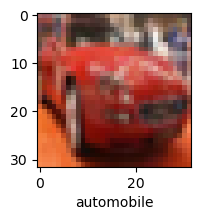

In [124]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

y_train = y_train.reshape(-1,)
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

def show_image(x, y, index):
    plt.figure(figsize=(15, 2))
    plt.imshow(x[index])
    plt.xlabel(class_names[y[index]])
    plt.show()

show_image(x_train, y_train, 5)

x_train = x_train/255
x_test = x_test/255

In [125]:

cnn2 = Sequential()
cnn2.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 3) ))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

cnn2.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

cnn2.add(Flatten())
cnn2.add(Dense(units=34, activation="relu"))
cnn2.add(Dense(units=10, activation="softmax"))

cnn2.compile(optimizer= 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = cnn2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1)



 113/1563 [=>............................] - ETA: 30s - loss: 2.1976 - accuracy: 0.1867

In [ ]:
y_predictions = cnn2.predict(x_test)
y_predictions[9]
y_predictions = [np.argmax(arr) for arr in y_predictions]
y_predictions

313/313 [==============================] - 1s 4ms/step


[3,
 8,
 8,
 8,
 6,
 6,
 3,
 2,
 3,
 1,
 0,
 9,
 5,
 7,
 9,
 6,
 5,
 3,
 8,
 6,
 7,
 0,
 2,
 1,
 4,
 6,
 4,
 2,
 9,
 6,
 6,
 2,
 2,
 3,
 9,
 3,
 7,
 1,
 9,
 5,
 8,
 6,
 5,
 6,
 8,
 9,
 3,
 3,
 4,
 4,
 9,
 8,
 6,
 3,
 8,
 8,
 7,
 8,
 3,
 3,
 7,
 5,
 4,
 1,
 6,
 6,
 1,
 0,
 3,
 7,
 2,
 6,
 8,
 8,
 1,
 2,
 8,
 5,
 3,
 8,
 8,
 8,
 1,
 5,
 2,
 7,
 2,
 8,
 9,
 9,
 8,
 4,
 8,
 6,
 4,
 6,
 6,
 8,
 5,
 3,
 5,
 5,
 6,
 3,
 1,
 8,
 8,
 6,
 5,
 5,
 7,
 0,
 2,
 2,
 1,
 3,
 0,
 5,
 6,
 7,
 8,
 2,
 1,
 2,
 8,
 2,
 8,
 3,
 3,
 2,
 4,
 1,
 9,
 9,
 1,
 3,
 9,
 7,
 2,
 8,
 2,
 5,
 3,
 5,
 8,
 3,
 6,
 6,
 5,
 5,
 8,
 1,
 6,
 9,
 2,
 5,
 2,
 9,
 5,
 2,
 2,
 1,
 6,
 6,
 8,
 4,
 8,
 4,
 7,
 0,
 9,
 9,
 8,
 8,
 9,
 9,
 2,
 7,
 5,
 9,
 8,
 7,
 6,
 2,
 7,
 8,
 6,
 3,
 5,
 8,
 2,
 8,
 9,
 9,
 7,
 4,
 8,
 2,
 7,
 8,
 3,
 8,
 8,
 7,
 1,
 3,
 8,
 5,
 7,
 8,
 3,
 8,
 5,
 8,
 8,
 2,
 2,
 9,
 0,
 4,
 7,
 3,
 9,
 5,
 3,
 9,
 6,
 2,
 2,
 6,
 3,
 1,
 3,
 1,
 8,
 0,
 2,
 9,
 5,
 3,
 1,
 1,
 8,
 9,
 0,
 6,
 7,
 8,
 2,
 8,


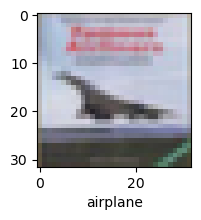

In [ ]:
y_test = y_test.reshape(-1, )
y_predictions[3]
show_image(x_test, y_test, 3)

313/313 - 1s - loss: 1.2248 - accuracy: 0.5663 - 1s/epoch - 4ms/step


TypeError: in user code:

    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\training.py", line 1502, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\engine\compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\metrics\base_metric.py", line 646, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\rvver\miniconda3\envs\iannwtf\lib\site-packages\keras\metrics\metrics.py", line 3330, in sparse_categorical_accuracy
        if matches.shape.ndims > 1 and matches.shape[-1] == 1:

    TypeError: '>' not supported between instances of 'NoneType' and 'int'


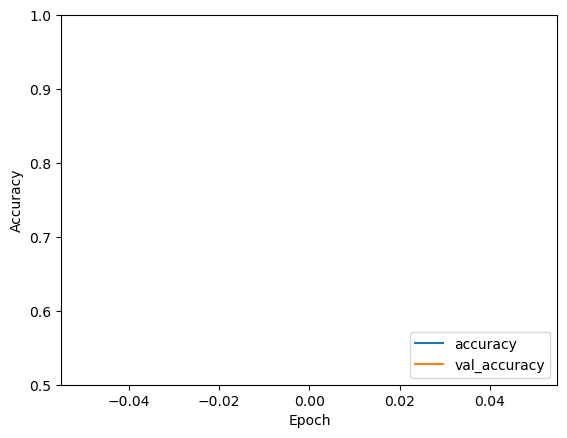

In [ ]:
#cnn2.evaluate(x_test, y_test)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = cnn2.evaluate(x_test,  y_test, verbose=2)
test_loss, test_acc = cnn2.evaluate(x_train, y_train, verbose=2)